# Machine Learning Explainability

**Outline**

* [Introduction](#intro)
* [Permutation Importance](#permutation)
    * [Code Example](#permutation_example)
* [Partial Dependency Plots](#pdp)
    * [Assumption/Drawback of Partial Dependency Plot](#assumption)
    * [Code Example](#pdp_example)
    * [The relationship between Permutation Importance and Partial Dependency](#permute_partial)
* [SHAP Values](#shap)
    * [How they work](#shap_how_work)
    * [Code Example](#shap_example)
    * [Advanced Uses of SHAP Values](#advanced_shap)
* [Reference](#refer)
* [Miscellneous Note](#miscell)
    * What is the cost function for Logistic Regression? How do MLE come into play?
    * What is the difference between cross entropy and entropy?
---

In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier

# library for permutation importance
import eli5
from eli5.sklearn import PermutationImportance

# library for partial dependency plot
from pdpbox import pdp, get_dataset, info_plots

# library for SHAP
import shap

import matplotlib.pyplot as plt
%reload_ext watermark
%matplotlib inline
%config InlineBackend.figure_format='retina'

%watermark -a 'Johnny' -d -t -v -p numpy,pandas,matplotlib,sklearn,eli5,pdpbox,shap

/Users/johnnychiu/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


Johnny 2019-02-13 18:24:03 

CPython 3.6.8
IPython 6.1.0

numpy 1.16.1
pandas 0.20.3
matplotlib 2.2.3
sklearn 0.19.1
eli5 0.8.1
pdpbox 0.2.0
shap 0.28.3


# <a id='intro'>Introduction</a>

Credit: The majority of the note in the post are mainly from the course [Machine Learning Explainability from Kaggle](https://www.kaggle.com/learn/machine-learning-explainability).

Many people say machine learning models are "black boxes", due to the reason that they they can make good predictions but you can't understand the logic behind those predictions.

Other than the common way of just using coefficients directly from the model result or using feature importance of tree-based models, there are actually other ways that we can use and things we need to consider.

In this post, we are going to introduce the following topics for better explaining the result from the model
* **Permutation Importance**
* **Partial Dependency Plot**
* **SHAP values**

## <a id='permutation'>Permutation Importance</a>

Usually when we build models, tree based models especially, when looking for the most important features, we usually look at feature importance, which is usually by default calculated by averaging the total information gain associated with a certain features across all the trees. However, according to the post [Beware Default Random Forest Importances](https://explained.ai/rf-importance/index.html), it say we need to be aware of it:
```
The scikit-learn Random Forest feature importance and R's default Random Forest feature importance strategies are biased. To get reliable results in Python, use permutation importance, provided here and in our rfpimp package (via pip). For R, use importance=T in the Random Forest constructor then type=1 in R's importance() function. In addition, your feature importance measures will only be reliable if your model is trained with suitable hyper-parameters.
```

The commonly used feature importance are biased in the sense that **it would tends to inflate the importance of continuous or high-cardinality categorical variables**. For example in 2007 Strobl et al pointed out in [Bias in random forest variable importance measures: Illustrations, sources and a solution](https://link.springer.com/article/10.1186%2F1471-2105-8-25) that “the variable importance measures of Breiman's original Random Forest method ... are not reliable in situations where potential predictor variables vary in their scale of measurement or their number of categories.” That's unfortunate because not having to normalize or otherwise futz with predictor variables for Random Forests is very convenient.

Breiman and Cutler, the creators of ramdom forest, described permutation importance, which measures the importance of a feature as follows. Record a baseline accuracy (classifier) or R2 score (regressor) by passing a validation set or the out-of-bag (OOB) samples through the Random Forest. Permute the column values of a single predictor feature and then pass all test samples back through the Random Forest and recompute the accuracy or R2. The importance of that feature is the difference between the baseline and the drop in overall accuracy or R2 caused by permuting the column. The permutation mechanism is much more computationally expensive than the mean decrease in impurity mechanism, but the results are more reliable. The permutation importance strategy does not require retraining the model after permuting each column; we just have to re-run the perturbed test samples through the already-trained model.

**Effect of low coverage features for Partial Dependency/Feature Importance/Permutation Importance**: Features with low coverage (most of the values are 0 or missing) can turns out to be important if we use partial dependency to see the effect, while using feature importance(total decrease in ) those features usually do not have high importance value. The reason is that there is still chance that the correlation of this low coverage feature to the response variable is high whereas when using average total information gain for this feature as feature importance, features with low coverage can not turn out to be important. Same concept can be applied to permutation importance. If a feature is with low coverage, no matter how we randomize that feature, it wouldn't affect the accuracy of the model.


In short, the process of getting permuation importance is as follows:

1. Get a trained model
2. Shuffle the values in a single column, make predictions using the resulting dataset. Use these predictions and the true target values to calculate how much the loss function suffered from shuffling. That performance deterioration measures the importance of the variable you just shuffled.
3. Return the data to the original order (undoing the shuffle from step 2.) Now repeat step 2 with the next column in the dataset, until you have calculated the importance of each column.

> <a id='permutation_example'>**Code Example**</a>

Our example will use a model that predicts whether a soccer/football team will have the "Man of the Game" winner based on the team's statistics. The "Man of the Game" award is given to the best player in the game. Model-building isn't our current focus, so the cell below loads the data and builds a rudimentary model.

In [2]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier

data = pd.read_csv('./_data/FIFA 2018 Statistics.csv')
y = (data['Man of the Match'] == "Yes")  # Convert from string "Yes"/"No" to binary
feature_names = [i for i in data.columns if data[i].dtype in [np.int64]]
X = data[feature_names]
train_X, val_X, train_y, val_y = train_test_split(X, y, random_state=1)
my_model = RandomForestClassifier(random_state=0).fit(train_X, train_y)

In [3]:
X.head()

,Goal Scored,Ball Possession %,Attempts,On-Target,Off-Target,Blocked,Corners,Offsides,Free Kicks,Saves,Pass Accuracy %,Passes,Distance Covered (Kms),Fouls Committed,Yellow Card,Yellow & Red,Red,Goals in PSO
0,5,40,13,7,3,3,6,3,11,0,78,306,118,22,0,0,0,0
1,0,60,6,0,3,3,2,1,25,2,86,511,105,10,0,0,0,0
2,0,43,8,3,3,2,0,1,7,3,78,395,112,12,2,0,0,0
3,1,57,14,4,6,4,5,1,13,3,86,589,111,6,0,0,0,0
4,0,64,13,3,6,4,5,0,14,2,86,433,101,22,1,0,0,0


Here is how to calculate and show importances with the [eli5](https://eli5.readthedocs.io/en/latest/) library

In [4]:
import eli5
from eli5.sklearn import PermutationImportance

perm = PermutationImportance(my_model, random_state=1).fit(val_X, val_y)
eli5.show_weights(perm, feature_names = val_X.columns.tolist())

Weight,Feature
0.0750 ± 0.1159,Goal Scored
0.0625 ± 0.0791,Corners
0.0437 ± 0.0500,Distance Covered (Kms)
0.0375 ± 0.0729,On-Target
0.0375 ± 0.0468,Free Kicks
0.0187 ± 0.0306,Blocked
0.0125 ± 0.0750,Pass Accuracy %
0.0125 ± 0.0500,Yellow Card
0.0063 ± 0.0468,Saves
0.0063 ± 0.0250,Offsides


> **Interpreting Permutation Importances**

* The values towards the top are the most important features, and those towards the bottom matter least.
* The weight shows the average performance decrease with a random permutation. The default number of permutation is 5 (n_iter=5). We measure the amount of randomness in our permutation importance calculation by repeating the process with multiple shuffles. The number after the ± measures how performance varied from one-reshuffling to the next.
* Negative values for permutation importances mean the performance happened to be more accurate than the real data, which usually happens when the feature didn't matter (should have had an importance close to 0) but random chance caused the predictions on shuffled data to be more accurate. This is more common with small datasets, like the one in this example, because there is more room for luck/chance.
* In our example, the most important feature was Goals scored. That seems sensible. Soccer fans may have some intuition about whether the orderings of other variables are surprising or not.

---

## <a id='pdp'>Partial Dependency Plots</a>

While feature importance/permutation importance shows what variables most affect predictions, it does not tell us whether if the feature affect the output positively or negatively. This is where partial dependence plots come into play. 

The goal of calculating partial dependency is to visualize the impact of certain features towards model prediction for any supervised learning algorithm. It can show whether the relationship between the target and a feature is linear, monotonous or more complex.

Let's use the following dummy dataframe to illustrate how to calculate partial dependency.

In [5]:
# dummy dataframe
data = pd.DataFrame({'x1':[1,1,2,2],
                     'x2':[1,4,2,3],
                     'x3':[3,3,4,1],
                     'y':[0,0,1,1]})
data

,x1,x2,x3,y
0,1,1,3,0
1,1,4,3,0
2,2,2,4,1
3,2,3,1,1


The process of getting permuation importance is as follows:

> **1. Get a trained model (partial dependence plots are calculated after a model has been fit). Let denote the model as `f`**

In [6]:
feature_names = ['x1','x2','x3']
X = data[feature_names]
y = data['y']  # Convert from string "Yes"/"No" to binary
pd_model = RandomForestClassifier(random_state=0).fit(X, y)

> **2. In the original data, replacing the targeted predictor to the value that we want to calculate the impact and get the average prediction for all the rows**

Let's say `x1` is the predictor that we are interested in knowing the partial dependency. The goal is to know the marginal effect 
* (x1=1, `f(x1=1)`) 
* (x1=2, `f(x1=2)`) 
* (x1=3, `f(x1=3)`), ...etc

To estimate `f(x1=1)`, we replace all the value of `x1` in the original table to be 1, and calculate the prediction for all the replaced rows, then averaging the prediction of all the rows to get the marginal effect when x1=1. By changing the value of x1, we can know the marginal effect of x1. 

In [7]:
x1_gridvalues = [i/10 for i in range(10,20,2)]
pd_x1_raw = []
for x1 in x1_gridvalues:
    data_x1 = pd.DataFrame({'x1':[x1]*4,
                         'x2':[1,4,2,3],
                         'x3':[1,3,4,1]})
    pd_x1_raw.append(pd_model.predict(data_x1))

print('The raw prediction when setting x1 to each of the gridline value in the original dataframe:')
print(pd_x1_raw)

# get the average marginal effect of each of the set value x1
pd_x1 = [np.mean(i) for i in pd_x1_raw]
print('\nMarginal effect of x1:')
print(pd_x1)

The raw prediction when setting x1 to each of the gridline value in the original dataframe:
[array([0, 0, 0, 0]), array([0, 0, 0, 0]), array([0, 0, 0, 0]), array([1, 0, 1, 1]), array([1, 0, 1, 1])]

Marginal effect of x1:
[0.0, 0.0, 0.0, 0.75, 0.75]


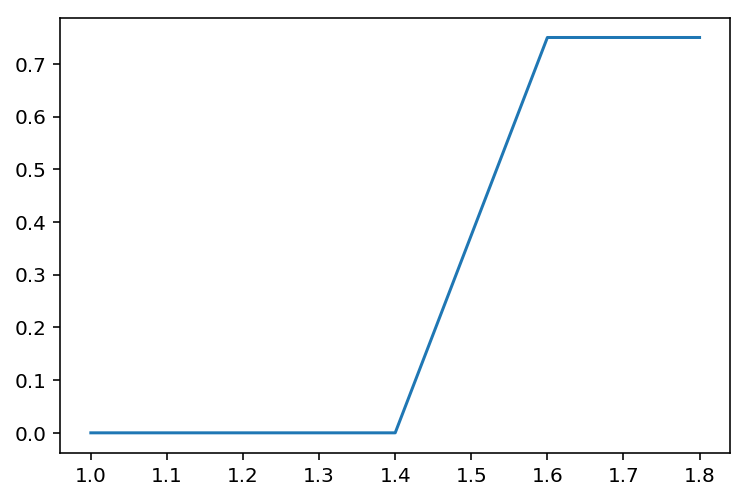

In [8]:
plt.plot(x1_gridvalues, pd_x1)
plt.show()

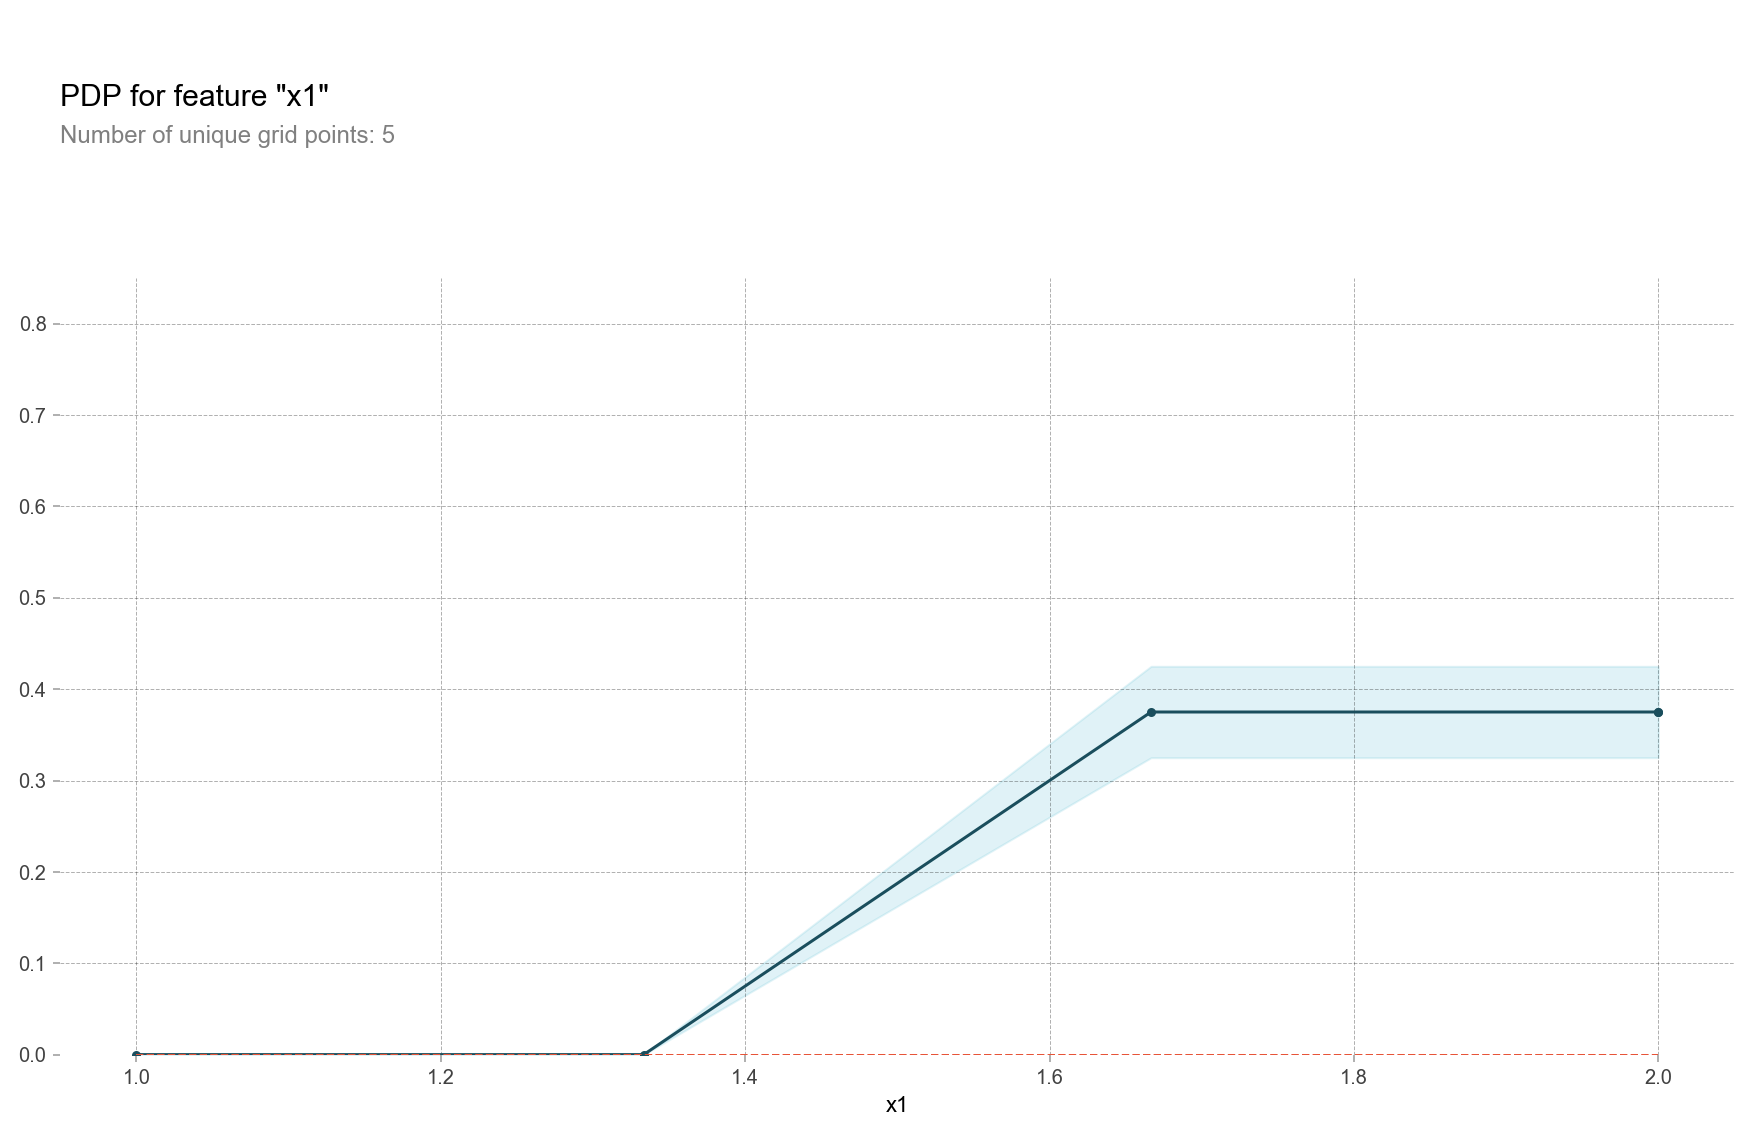

In [9]:
from pdpbox import pdp, get_dataset, info_plots

# Create the data that we will plot
pdp_dist = pdp.pdp_isolate(model=pd_model, dataset=X, model_features=feature_names, feature='x1')

# plot it
pdp.pdp_plot(pdp_dist, 'x1')
plt.show()

We can see that the absoluate value of y-axis from the two plots is different, and we would need to dig further into the documentation to find out why. For now, we know that the overal trend from the one that we implemented from scratch and the one generated by PDPbox is similar. As expected, the effect of `x1` is positive.

Partial dependence plots can be interepreted similarly to the coefficients in linear and logistics models. Though, partial dependence plots on sophisticated models can capture more complex patterns than coefficients from simple models.

> <a id='assumption'>**Assumption/Drawback of Partial Dependency Plot**</a>

<font color='red'>**One assumption made for the PDP is that the features in $X_C$ are uncorrelated with the features in $X_S$**</font>. If this assumption is violated, the averages, which are computed for the partial dependence plot, incorporate data points that are very unlikely or even impossible.

For example, it’s unreasonable to claim that height and weight is uncorrelated. If height is the feature to plot, only changing height through different values would create data points like someone is 2 meters but weighting below 50kg. Considering PDP is calculated by averaging through all data points, with these kind of unreasonable data points, the result might not be trustworthy.

Reference: [References and Notes from PDPbox library](https://pdpbox.readthedocs.io/en/latest/papers.html)

This is why Professor Dan Apley created Accumulated Local Effects(ALE) plot. To know more about the details, please see [R package ALEPlot: Accumulated Local Effects (ALE) Plots and Partial Dependence (PD) Plots by Prof Apley](https://cran.r-project.org/web/packages/ALEPlot/index.html) and [Accumulated Local Effects (ALE) Plot by Christoph Molnar](https://christophm.github.io/interpretable-ml-book/ale.html)

> <a id='pdp_example'>**Code Example**</a>

The example is borrowed from [Kaggle Course by DanB](https://www.kaggle.com/dansbecker/partial-plots).

Same as the example used for permutation importance. We would like to use models to predicts whether a soccer/football team will have the "Man of the Game" winner based on the team's statistics. The "Man of the Game" award is given to the best player in the game.

In [10]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier

data = pd.read_csv('./_data/FIFA 2018 Statistics.csv')
y = (data['Man of the Match'] == "Yes")  # Convert from string "Yes"/"No" to binary
feature_names = [i for i in data.columns if data[i].dtype in [np.int64]]
X = data[feature_names]
train_X, val_X, train_y, val_y = train_test_split(X, y, random_state=1)
tree_model = DecisionTreeClassifier(random_state=0, max_depth=5, min_samples_split=5).fit(train_X, train_y)

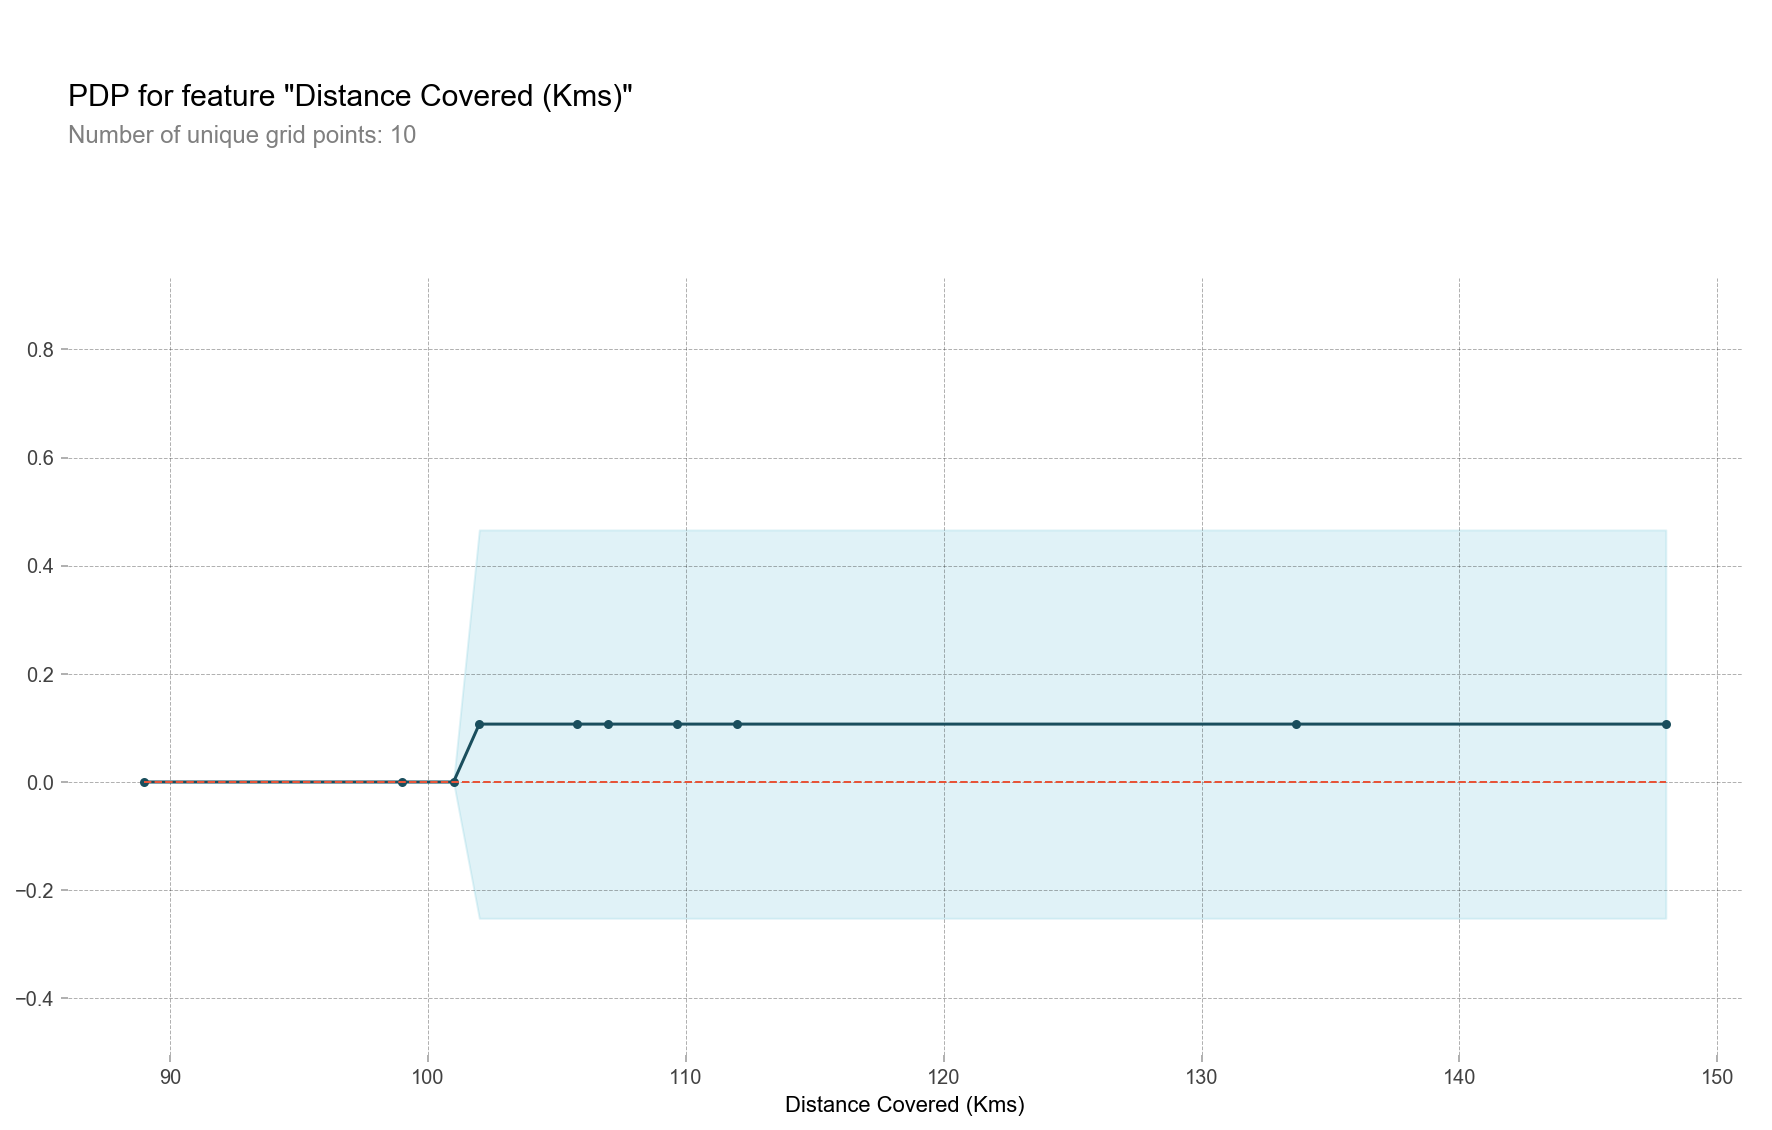

In [11]:
from matplotlib import pyplot as plt
from pdpbox import pdp, get_dataset, info_plots

feature_to_plot = 'Distance Covered (Kms)'
pdp_dist = pdp.pdp_isolate(model=tree_model, dataset=val_X, model_features=feature_names, feature=feature_to_plot)

pdp.pdp_plot(pdp_dist, feature_to_plot)
plt.show()

A few items are worth pointing out as you interpret this plot

* The y axis is interpreted as change in the prediction from what it would be predicted at the baseline or leftmost value.
* A blue shaded area indicates level of confidence, which are obtained from the prediction using the rows with replaced values of the predictor of interest.

This graph seems too simple to represent reality. But that's because the model is so simple. You should be able to see from the decision tree above that this is representing exactly the model's structure.

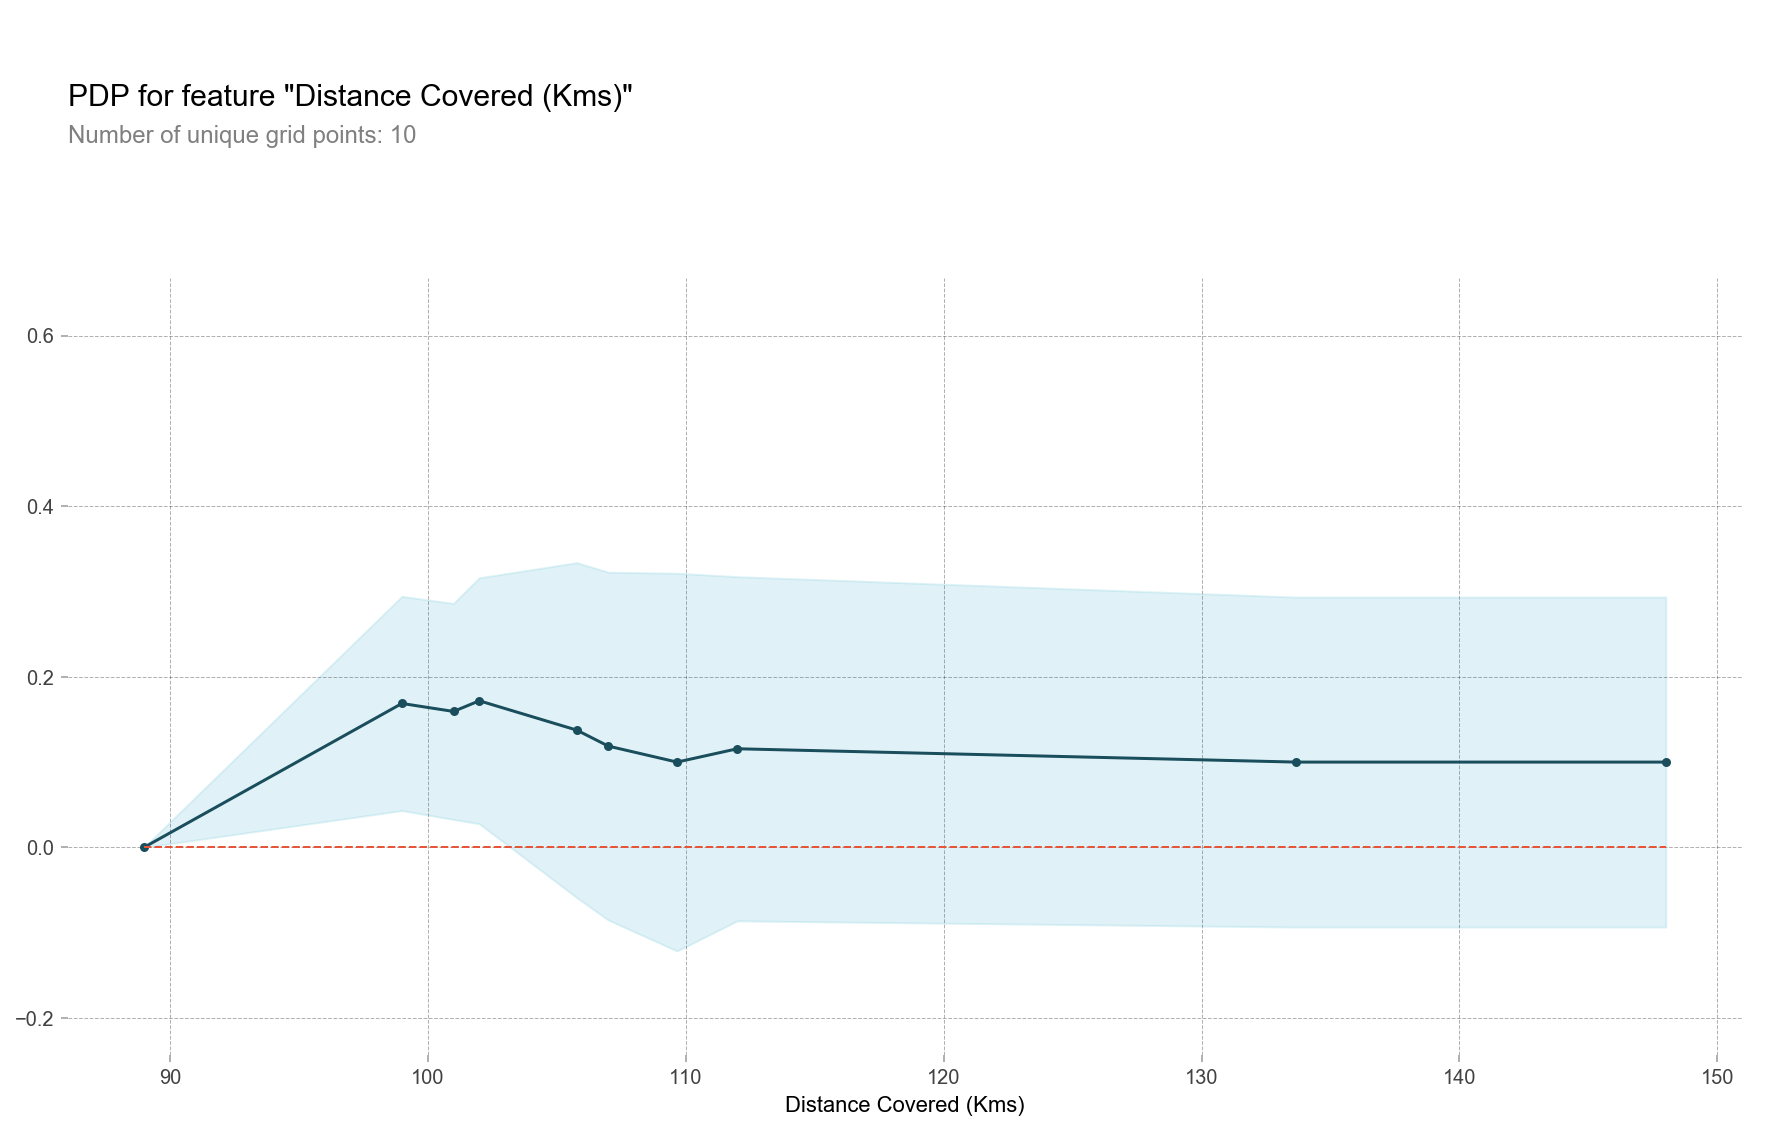

In [12]:
# Build Random Forest model
rf_model = RandomForestClassifier(random_state=0).fit(train_X, train_y)

pdp_dist = pdp.pdp_isolate(model=rf_model, dataset=val_X, model_features=feature_names, feature=feature_to_plot)

pdp.pdp_plot(pdp_dist, feature_to_plot)
plt.show()

This model thinks you are more likely to win Player of The Game if your players run a total of 100km over the course of the game. Though running much more causes lower predictions.

**2D Partial Dependence Plots**

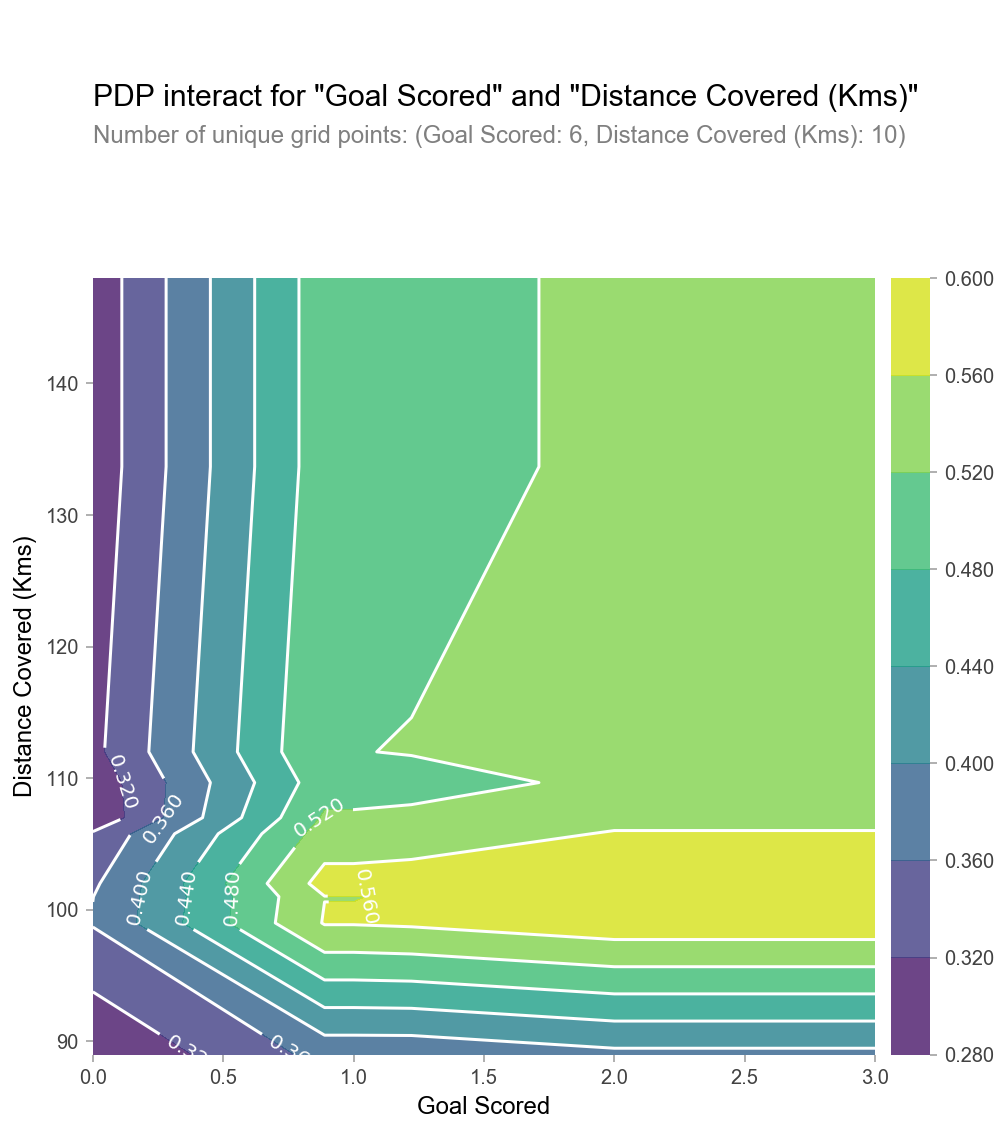

In [13]:
# Similar to previous PDP plot except we use pdp_interact instead of pdp_isolate and pdp_interact_plot instead of pdp_isolate_plot
# note: make sure to use matplotlib version 2.x.x not 3.x.x (https://github.com/SauceCat/PDPbox/issues/37)
features_to_plot = ['Goal Scored', 'Distance Covered (Kms)']
inter1  =  pdp.pdp_interact(model=rf_model, dataset=val_X, model_features=feature_names, features=features_to_plot)

pdp.pdp_interact_plot(pdp_interact_out=inter1, feature_names=features_to_plot, plot_type='contour')
plt.show()

This graph shows predictions for any combination of Goals Scored and Distance covered.

For example, we can see that
* The highest predictions when a team scores at least 1 goal and they run a total distance close to 100km. If they score 0 goals or less than 1 goals, distance covered doesn't matter. 
* Distance can impact predictions if they score goals. Generally when they run a total distance close to 100km, they would have the highest probabilty of having the Man of the Year. When they run close to 110km, the decrease in probabiltiy of the "Man of the Year" is larger when the team only score 1-1.6 point. In other words, if the team doesn't score that much (>2), and travel a lot of distance on court, the chance of having the Man of the Year would decrease since those runs are inefficient runs.
* Overall, the plot also shows that there is an interaction between these two features, since the effect of Distance covered to the probability of having Man of the Year would be affected by how much a team scores. If there is not interaction, than the plot should be dominating by one of the feature. The contour of the plot should be either all horizontal or vertical lines.

Another example can be seen here: [tutorial of the PDPbox author, SauceCat](https://github.com/SauceCat/PDPbox/blob/master/tutorials/pdpbox_regression.ipynb). This one is based on [Rossmann Store Sales](https://www.kaggle.com/c/otto-group-product-classification-challenge/data).

> <a id='permute_partial'>**The relationship between Permutation Importance and Partial Dependency**</a>

**Question 1**
Consider a scenario where you have only 2 predictive features, which we will call `feat_A` and `feat_B`. Both features have minimum values of -1 and maximum values of 1.  The partial dependence plot for `feat_A` increases steeply over its whole range, whereas the partial dependence plot for feature B increases at a slower rate (less steeply) over its whole range.**

Does this guarantee that `feat_A` will have a higher permutation importance than `feat_B`.  Why or why not?

**Answer**
No. This doesn't guarantee feat_a is more important. For example, feat_a could have a big effect in the cases where it varies, but could have a single value 99% of the time. In that case, permuting feat_a wouldn't matter much, since most values would be unchanged.

---
**Question 2**
Do higher permutation importance imply more impact (can be either positive or negative) on partial dependency?

**Answer**
Generally the result should agree with other, but there can be cases when the result doesn't agree, such as
* [Relationship between Partial dependence plot and Feature Importance](https://stackoverflow.com/questions/51869108/relationship-between-partial-dependence-plot-and-feature-importance)
* [Why do my Feature Importance and Partial Dependence plots not agree?](https://stats.stackexchange.com/questions/288040/why-do-my-feature-importance-and-partial-dependence-plots-not-agree)

Let's use the example from the [Kaggle kernel](https://www.kaggle.com/kernels/notebooks/new?forkParentScriptVersionId=10290774&userName=johnnychiuhciu). The example manually generate a dataset with 2 features and a target, such that the pdp of the first feature is flat, but its permutation importance is high. We will use a RandomForest for the model.

The hint of generating such dataset is that we need for X1 to affect the prediction in order to have it affect permutation importance. But the average effect needs to be 0 to satisfy the PDP requirement. Achieve this by creating an interaction, so the effect of X1 depends on the value of X2 and vice-versa.

In other words, when there is interaction between X1 and X2 to the response variable y, either of the feature could be important in term of permutation importance (randomly change one of the feature would defintely decrease the model performance, since both the interaction effect and the effect of that feature would disappear).

---

To sum up, permutation importance and partial dependency are two way to look at how the predictor can affect the response. While it would generally agree, one result doesn't imply another.

* **High permutation importance doesn't imply high partial dependency is proven by question 2 for the reason of interaction**
* **High partial dependency doesn't imply high permutation importance is proven by question 1 for the reason of feature value coverage**

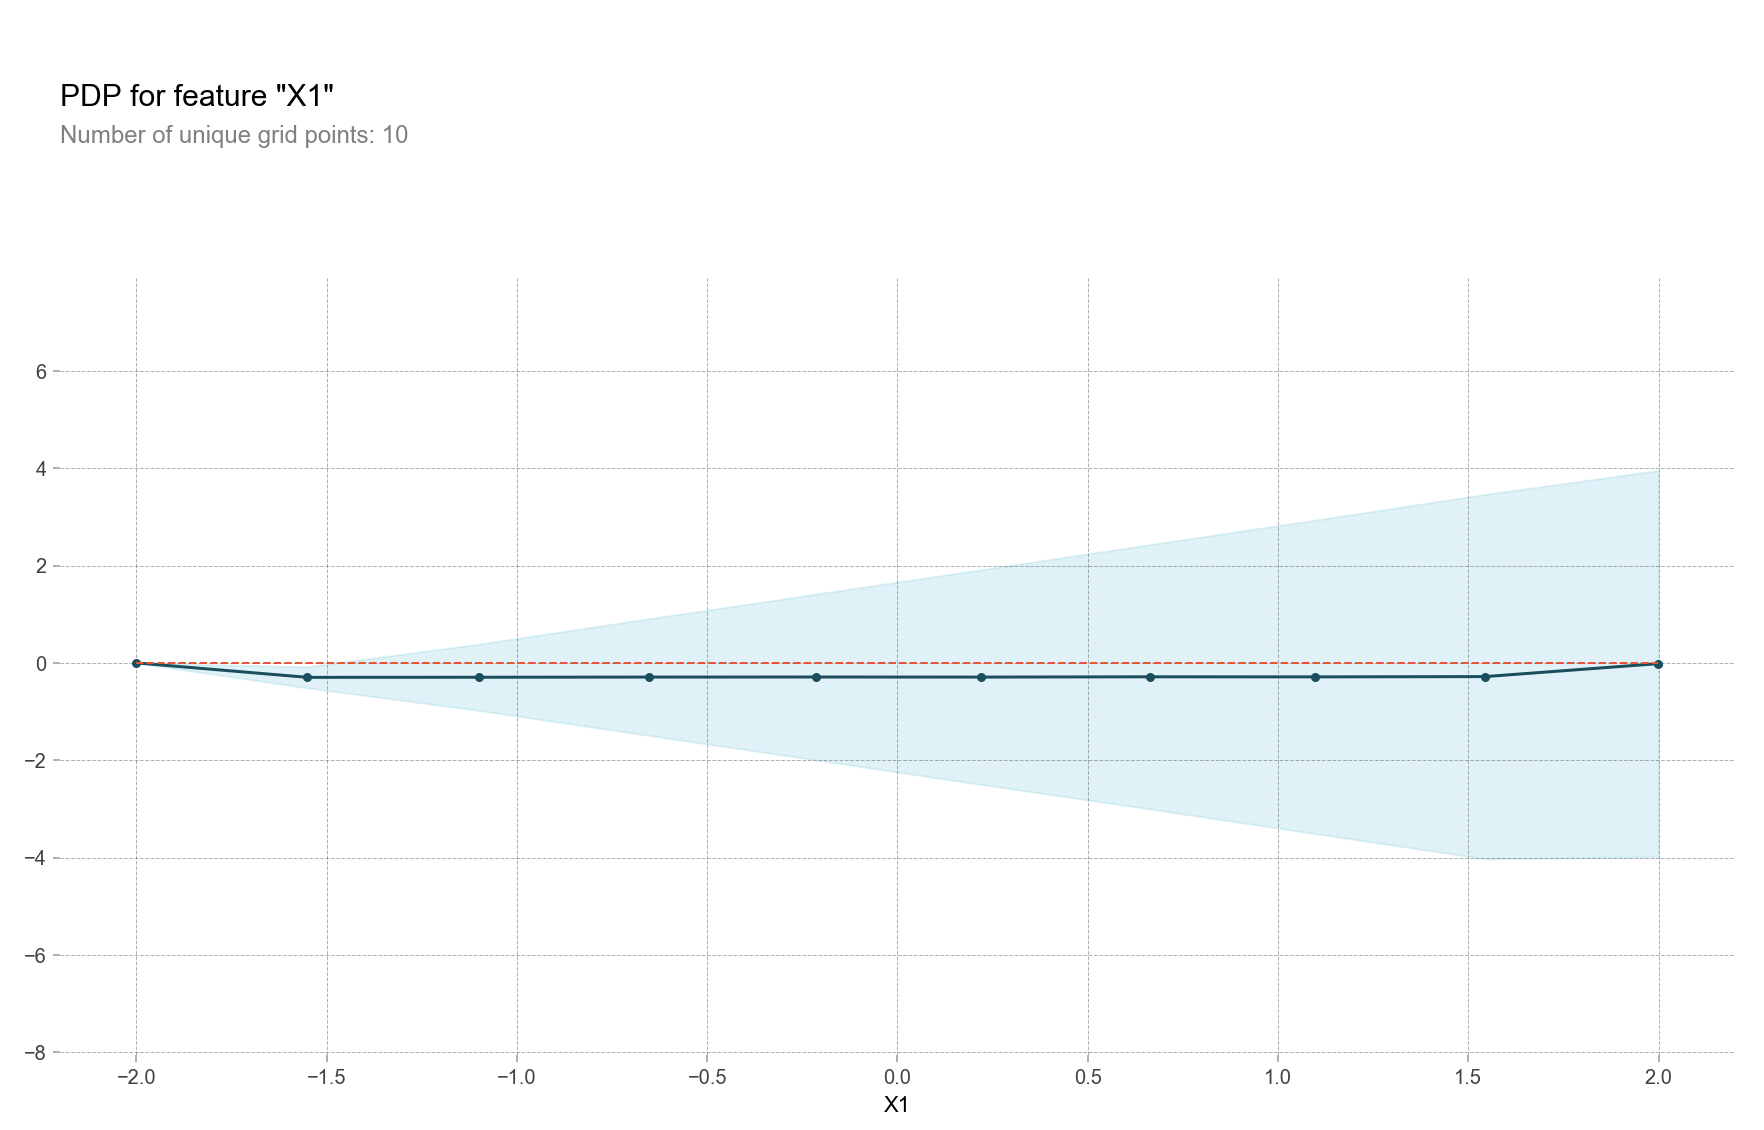

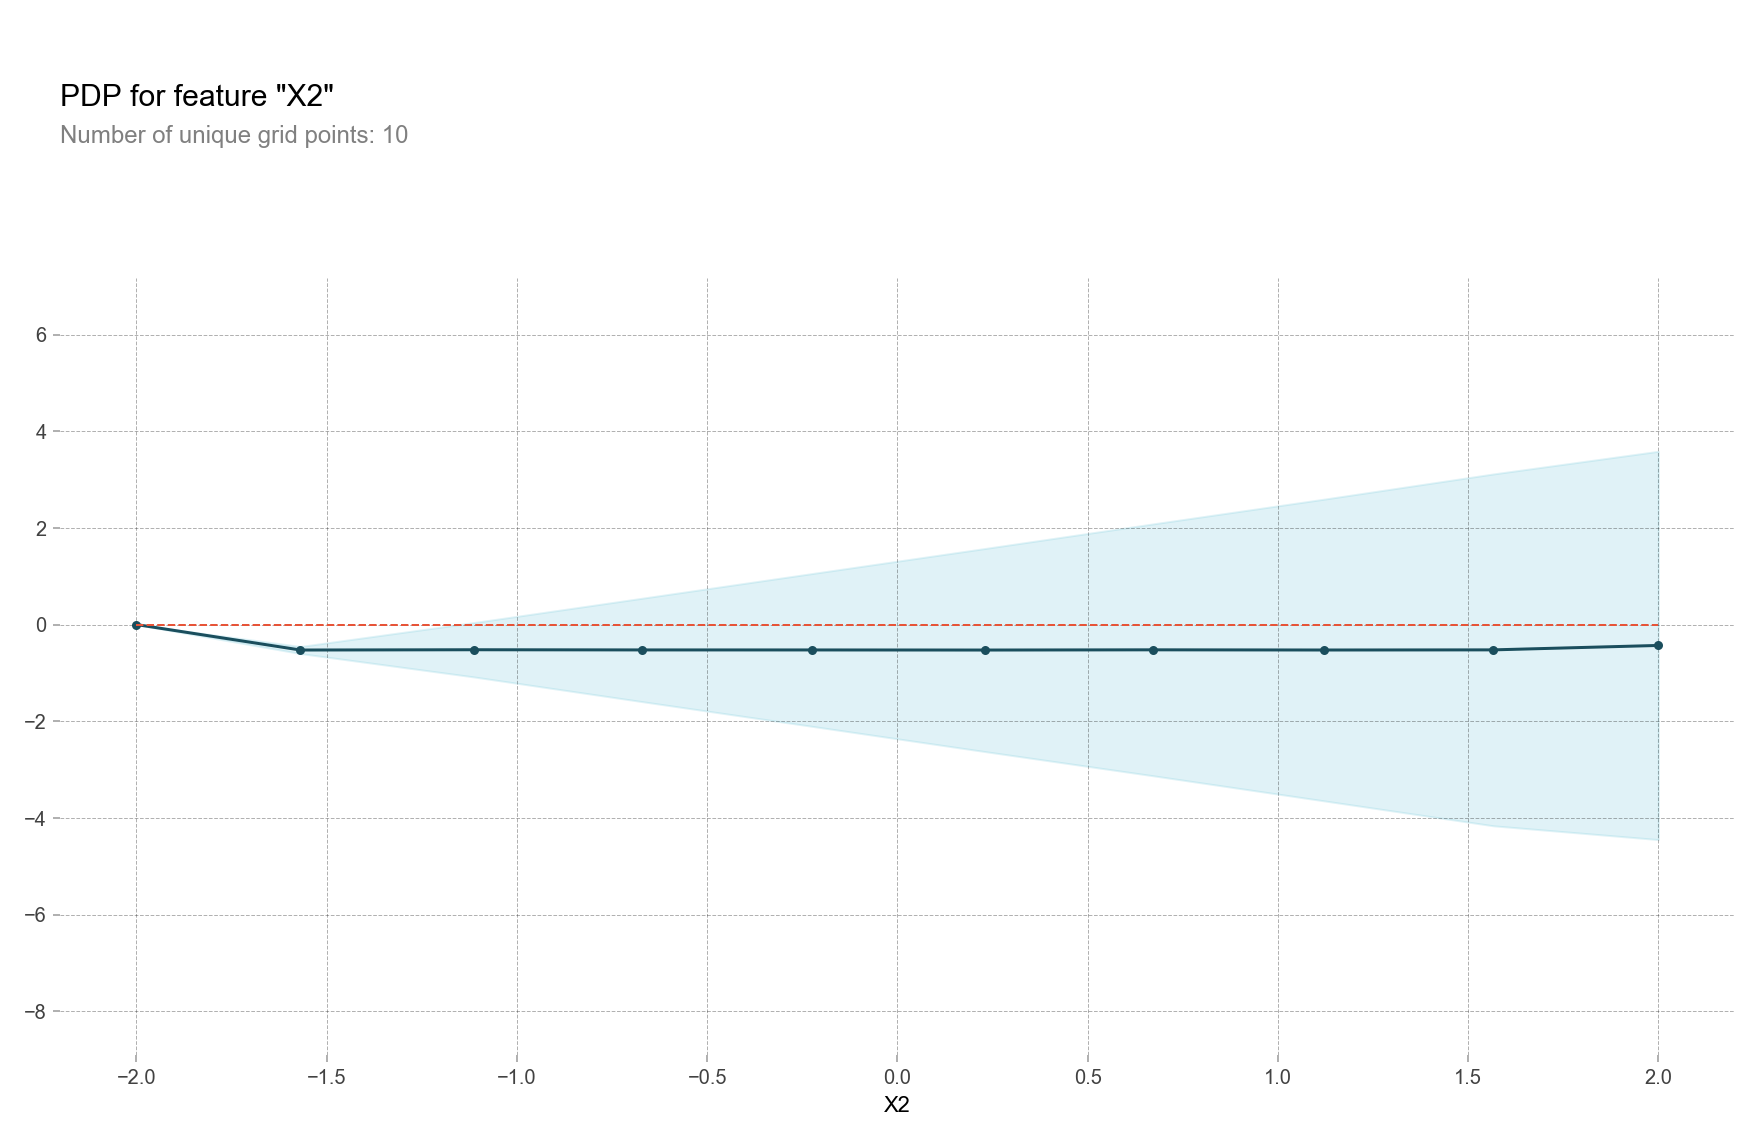

Weight,Feature
2.0042 ± 0.0347,X1
1.9990 ± 0.0482,X2


In [14]:
from sklearn.ensemble import RandomForestRegressor
import eli5
from eli5.sklearn import PermutationImportance
from numpy.random import rand

n_samples = 20000

# Create array holding predictive feature
X1 = 4 * rand(n_samples) - 2
X2 = 4 * rand(n_samples) - 2
# Create y. you should have X1 and X2 in the expression for y
y = X1 * X2


# create dataframe because pdp_isolate expects a dataFrame as an argument
my_df = pd.DataFrame({'X1': X1, 'X2': X2, 'y': y})
predictors_df = my_df.drop(['y'], axis=1)

my_model = RandomForestRegressor(n_estimators=30, random_state=1).fit(predictors_df, my_df.y)

for feat in ['X1','X2']:
    pdp_dist = pdp.pdp_isolate(model=my_model, dataset=my_df, model_features=['X1', 'X2'], feature=feat)
    pdp.pdp_plot(pdp_dist, feat)
plt.show()

perm = PermutationImportance(my_model).fit(predictors_df, my_df.y)

# show the weights for the permutation importance you just calculated
eli5.show_weights(perm, feature_names = ['X1', 'X2'])

---

## <a id='shap'>SHAP Values</a>

[SHAP](https://github.com/slundberg/shap) Values (an acronym from SHapley Additive exPlanations) break down a prediction to show the impact of each feature. Where could you use this?

* A model says a bank shouldn't loan someone money, and the bank is legally required to explain the basis for each loan rejection
* A healthcare provider wants to identify what factors are driving each patient's risk of some disease so they can directly address those risk factors with targeted health interventions

You'll use SHAP Values to explain individual predictions.

> <a id='shap_how_work'>**How They Work**</a>

SHAP values interpret the impact of having a certain value for a given feature in comparison to the prediction we'd make if that feature took some baseline value.

An example is helpful, and we'll continue the soccer/football example from the permutation importance and partial dependence plots lessons.

In these tutorials, we predicted whether a team would have a player win the Man of the Game award.

We could ask:

* How much was a prediction driven by the fact that the team scored 3 goals?
But it's easier to give a concrete, numeric answer if we restate this as:

* How much was a prediction driven by the fact that the team scored 3 goals, instead of some baseline number of goals.
Of course, each team has many features. So if we answer this question for number of goals, we could repeat the process for all other features.

SHAP values do this in a way that guarantees a nice property. When we make a prediction

`sum(SHAP values for all features) = pred_for_team - pred_for_baseline_values`

That is, the SHAP values of all features sum up to explain why my prediction was different from the baseline. This allows us to decompose a prediction in a graph like this:

<img src="https://i.imgur.com/JVD2U7k.png" style="width: 950px;height: 94px;"/>

How do you interpret this?

We predicted 0.7, whereas the base_value is 0.4979. Feature values causing increased predictions are in pink, and their visual size shows the magnitude of the feature's effect. Feature values decreasing the prediction are in blue. The biggest impact comes from Goal Scored being 2. Though the ball possession value has a meaningful effect decreasing the prediction.

If you subtract the length of the blue bars from the length of the pink bars, it equals the distance from the base value to the output.

There is some complexity to the technique, to ensure that the baseline plus the sum of individual effects adds up to the prediction (which isn't as straightforward as it sounds.) We won't go into that detail here, since it isn't critical for using the technique. [This blog post](https://towardsdatascience.com/one-feature-attribution-method-to-supposedly-rule-them-all-shapley-values-f3e04534983d) has a longer theoretical explanation.

> <a id='shap_example'>**Code Example**</a>

For this example, we'll reuse the model you've already seen with the Soccer data.

In [15]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier

data = pd.read_csv('./_data/FIFA 2018 Statistics.csv')
y = (data['Man of the Match'] == "Yes")  # Convert from string "Yes"/"No" to binary
feature_names = [i for i in data.columns if data[i].dtype in [np.int64, np.int64]]
X = data[feature_names]
train_X, val_X, train_y, val_y = train_test_split(X, y, random_state=1)
my_model = RandomForestClassifier(random_state=0).fit(train_X, train_y)

We will look at SHAP values for a single row of the dataset (we arbitrarily chose row 5). For context, we'll look at the raw predictions before looking at the SHAP values

In [16]:
row_to_show = 5
data_for_prediction = val_X.iloc[row_to_show]  # use 1 row of data here. Could use multiple rows if desired
data_for_prediction_array = data_for_prediction.values.reshape(1, -1)

my_model.predict_proba(data_for_prediction_array)

array([[0.3, 0.7]])

The team is 70% likely to have a player win the award.

Now, we'll move onto the code to get SHAP values for that single prediction.

In [17]:
import shap  # package used to calculate Shap values

# Create object that can calculate shap values
explainer = shap.TreeExplainer(my_model)

# Calculate Shap values
shap_values = explainer.shap_values(data_for_prediction)

The shap_values object above is a list with two arrays. The first array is the SHAP values for a negative outcome (don't win the award), and the second array is the list of SHAP values for the positive outcome (wins the award). We typically think about predictions in terms of the prediction of a positive outcome, so we'll pull out Shap values for positive outcomes (pulling out shap_values[1].)

It's cumbersome to review raw arrays, but the shap package has a nice way to visualize the results.

In [18]:
shap.initjs()
shap.force_plot(explainer.expected_value[1], shap_values[1], data_for_prediction)

If you look carefully at the code where we created the SHAP values, you'll notice we reference Trees in **shap.TreeExplainer(my_model)**. But the SHAP package has explainers for every type of model.

* **shap.DeepExplainer** works with Deep Learning models.
* **shap.KernelExplainer** works with all models, though it is slower than other Explainers and it offers an approximation rather than exact Shap values.

Here is an example using `KernelExplainer` to get similar results. The results aren't identical because kernelExplainer gives an approximate result. But the results tell the same story.

In [19]:
# use Kernel SHAP to explain test set predictions
k_explainer = shap.KernelExplainer(my_model.predict_proba, train_X)
k_shap_values = k_explainer.shap_values(data_for_prediction)
shap.force_plot(k_explainer.expected_value[1], k_shap_values[1], data_for_prediction)

> <a id='advanced_shap'>**Advanced Uses of SHAP Values**</a>

After having the SHAP value, we can actually use it in many different useful ways to see the indivisual impact of each observation to the whole model. Please refer to this post to learn more: [Advanced Uses of SHAP Values](https://www.kaggle.com/dansbecker/advanced-uses-of-shap-values)

---
## <a id='refer'>Reference</a>

* Permutation Importance
    * [Beware Default Random Forest Importances](https://explained.ai/rf-importance/index.html)
    * [Bias in random forest variable importance measures: Illustrations, sources and a solution](https://link.springer.com/article/10.1186%2F1471-2105-8-25)
    * [Random Forest creator's explaination on variance importance](https://www.stat.berkeley.edu/~breiman/RandomForests/cc_home.htm#varimp)
* Partial Dependency Plot    
    * [Partial Dependence Plot (PDP) by Christoph Molnar](https://christophm.github.io/interpretable-ml-book/pdp.html)
    * [Introducing PDPbox](https://towardsdatascience.com/introducing-pdpbox-2aa820afd312)
    * [PDPbox github](https://github.com/SauceCat/PDPbox/blob/master/docs/papers.rst)
    * [Partial Dependency Plot by Ethen Liu](https://nbviewer.jupyter.org/github/ethen8181/machine-learning/blob/master/model_selection/partial_dependence/partial_dependence.ipynb)
* Others
    * [Post about SLOW CONDA ENVIRONMENT SOLVING](https://www.jakevc.com/blog/slow-conda-environment-solving/)
    * [Jupter Widgets](https://jupyter.org/widgets)
* Posts to solve SHAP package installation issues    
    * [C extentions is not build during install](https://github.com/slundberg/shap/issues/96)    
        * solved by using the command
            * pip uninstall shap
            * git clone https://github.com/slundberg/shap
    * [ImportError: cannot import name '_validate_lengths'](https://stackoverflow.com/questions/54241226/importerror-cannot-import-name-validate-lengths    )
        * solved by using the command
            * pip install --upgrade scikit-image    

---

# <a id='miscell'>Miscellneous Topics</a>


### 1. What is the cost function for Logistic Regression? How do MLE come into play?

There are 2 approaches to obtain coefficients for Logistic regression.

> **Use *Cross Entropy* as the cost function, and use gradient descent to obtain it.**

Cross Entropy (same as log-loss)

$$\begin{cases}
    -log(p)       & \quad \text{if } y \text{ = 1}\\
    -log(1-p)  & \quad \text{if } y \text{ = 0}
\end{cases}$$

or can be represented as one equation

$$-(ylog(p)+(1-y)log(1-p))$$

<img src="https://ml-cheatsheet.readthedocs.io/en/latest/_images/cross_entropy.png" style="width: 600px;height: 450px;"/>

The graph above shows the range of possible loss values given a true observation (isDog = 1). As the predicted probability approaches 1, log loss slowly decreases. As the predicted probability decreases, however, the log loss increases rapidly. Log loss penalizes both types of errors, but especially those predictions that are confident and wrong!

Also reference to the content [here](https://ml-cheatsheet.readthedocs.io/en/latest/logistic_regression.html#cost-function)

> **use MLE to estimate the coefficient of logistic regression**

Maximize the log-likelihood function, which looks very similar to the cross-entropy that we see above except with the positive sign. The goal is to get the parameters that maximize the log-likelihood function (instead of minimize the cross entropy cost function as shown above). For more detail, please see [post for logistic regression](https://nbviewer.jupyter.org/github/johnnychiuchiu/Machine-Learning/blob/master/LogisticRegression/logisticRegression.ipynb#coef).



### 2. What is the difference between cross entropy and entropy?

Please see the answer from Quora [here](https://www.quora.com/What-is-the-difference-between-cross-entropy-and-entropy)

In short:
* Entropy is a function of a single distribution. It is usually used in the context of decision tree to measure the impurity of the split
* Cross entropy is a function of two distribution. It is usually used as the cost function for classification models. Reference [here](https://ml-cheatsheet.readthedocs.io/en/latest/loss_functions.html#cross-entropy) to see a list of commonly used cost functions.